Best Abelian Δ ≈ 0.1796 at ω ≈ 1.754 rad;  p_switch ≈ 1.0000
Best non-Abelian Δ ≈ 0.1796 at ω ≈ 1.754 rad;  p_switch ≈ 1.0000,  p_fixed ≈ 0.8204


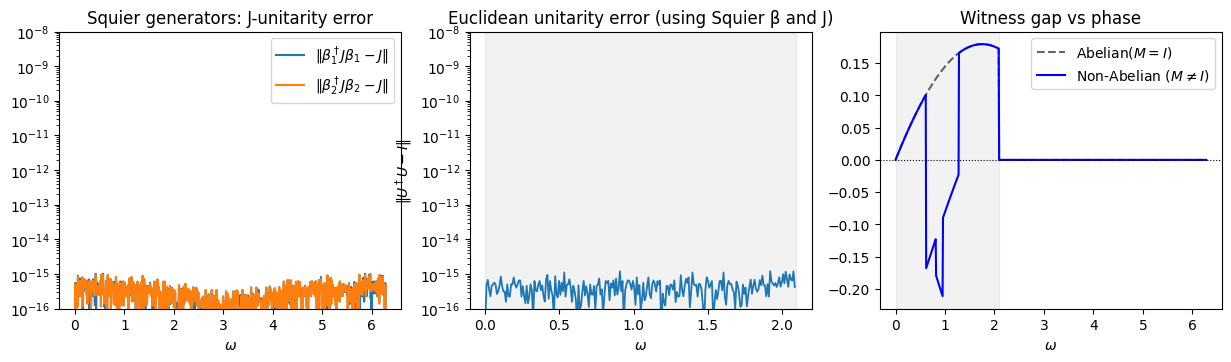

In [2]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

# ----------------- Squier data (B3: 2×2 case) -----------------

def J_squier_B3(omega):
    """
    Squier's Hermitian form for the 2×2 reduced block (n=3 → m=2):
      J(ω) = (s + s^{-1}) I - (shift_up + shift_down),
    with s = e^{i ω/2} → s + s^{-1} = 2 cos(ω/2).
    """
    c = 2*np.cos(omega/2.0)
    J = np.array([[c, -1],
                  [-1, c]], dtype=complex)
    return J

def beta_B3_sigma(i, s):
    """
    Squier's modified generators β_i (restricted to 2×2 reduced block).
    Reference form (with s^2 = t):
      β_1 = [[-s^2,  s ],
             [  0  ,  1 ]]
      β_2 = [[  1 ,  0 ],
             [  s , -s^2]]
    """
    if i == 1:
        return np.array([[-s**2,  s],
                         [    0,  1]], dtype=complex)
    elif i == 2:
        return np.array([[   1,  0],
                         [   s, -s**2]], dtype=complex)
    else:
        raise ValueError("i must be 1 or 2")

def beta_word_B3(word, s, right_mult=True):
    """
    Build a word from β-generators (Squier’s), e.g. "s1 s2^-1 s1".
    """
    if isinstance(word, str):
        w = []
        for tok in word.replace(",", " ").split():
            tok = tok.strip()
            if not tok: continue
            assert tok[0] in "sσ", "Use tokens like s1, s2^-1"
            core = tok[1:]
            if "^" in core:
                idx, pw = core.split("^", 1); p = int(pw)
            else:
                idx, p = core, 1
            w.append((int(idx), p))
        word = w
    M = np.eye(2, dtype=complex)
    for i, p in word:
        B = beta_B3_sigma(i, s)
        if p < 0:
            B = LA.inv(B); p = -p
        for _ in range(p):
            M = M @ B if right_mult else B @ M
    return M

# ----------------- J-unitarization and checks -----------------

def cholesky_like(J, tol=1e-12):
    vals, vecs = LA.eigh(J)
    if np.min(vals.real) <= tol:
        return None, vals
    R = vecs @ np.diag(np.sqrt(vals)) @ vecs.conj().T
    return R, vals

def unitary_from_J(M0, J):
    R, _ = cholesky_like(J)
    if R is None: return None
    return R @ M0 @ LA.inv(R)

# ----------------- Helstrom witness (same as before) -----------------

def helstrom_unitary_success(U0, U1):
    W = U0.conj().T @ U1
    vals = LA.eigvals(W)
    ang  = np.sort(np.angle(vals))
    span = float(np.max(ang) - np.min(ang))
    Delta = min(span, 2*np.pi - span)
    return 0.5*(1 + np.sin(Delta/2))

def switch_unitary(A, B, theta):
    P0 = np.array([[1,0],[0,0]], dtype=complex)
    P1 = np.array([[0,0],[0,1]], dtype=complex)
    return np.kron(P0, B@A) + np.exp(1j*theta)*np.kron(P1, A@B)

def Rx(theta):
    c, s = np.cos(theta/2), -1j*np.sin(theta/2)
    return np.array([[c, s],[s, c]], dtype=complex)
def Rz(phi):
    return np.array([[np.exp(-1j*phi/2), 0],[0, np.exp(1j*phi/2)]], dtype=complex)

# ----------------- Demo parameters -----------------

word = "s1 s2 s1"     # any short braid word in B3
grid = 721
omegas = np.linspace(0, 2*np.pi, grid, endpoint=True)

# target unitaries for the witness plot
A = Rx(1.1); B = Rz(0.9)
p_fixed = max(helstrom_unitary_success(np.eye(2), B@A),
              helstrom_unitary_success(np.eye(2), A@B))

# ----------------- Scan ω: prove β_i are J-unitary, unitarize word, compute gap -----------------

pd_mask   = np.zeros_like(omegas, dtype=bool)
unit_err  = np.full_like(omegas, np.nan, dtype=float)
p_switch_ab  = np.zeros_like(omegas, dtype=float)
p_switch_nab = np.zeros_like(omegas, dtype=float)
gap_ab    = np.zeros_like(omegas, dtype=float)
gap_nab   = np.zeros_like(omegas, dtype=float)
betaJerrs = np.zeros((2, grid), dtype=float)   # ||β_i† J β_i - J|| for i=1,2

for j, w in enumerate(omegas):
    s = np.exp(1j*w/2.0)
    J = J_squier_B3(w)
    # verify β_i† J β_i = J
    for i in (1,2):
        Bi = beta_B3_sigma(i, s)
        betaJerrs[i-1, j] = LA.norm(Bi.conj().T @ J @ Bi - J)
    # PD and Euclidean unitarization of the word
    R, vals = cholesky_like(J)
    pd_mask[j] = R is not None
    # mixers M_pre = M_post = M0
    M0 = beta_word_B3(word, s, right_mult=True)
    U  = unitary_from_J(M0, J)
    if U is not None:
        unit_err[j] = LA.norm(U.conj().T @ U - np.eye(2))
        # switch
        S = switch_unitary(A, B, theta=w) # choose θ(ω)=ω
        p_switch_ab[j] = helstrom_unitary_success(np.eye(4), S)
        gap_ab[j] = p_switch_ab[j] - p_fixed
        # test device
        T = np.kron(U, np.eye(2)) @ S @ np.kron(U, np.eye(2))
        # witness gap
        p_switch_nab[j] = helstrom_unitary_success(np.eye(4), T)
        gap_nab[j] = p_switch_nab[j] - p_fixed

# ----------------- Plots -----------------

fig, axs = plt.subplots(1, 3, figsize=(15.0, 3.6))

# (1) β_i J-unitarity check
axs[0].plot(omegas, betaJerrs[0], label=r"$\|\beta_1^\dagger J \beta_1 - J\|$")
axs[0].plot(omegas, betaJerrs[1], label=r"$\|\beta_2^\dagger J \beta_2 - J\|$")
axs[0].set_yscale("log"); axs[0].set_ylim(1e-16, 1e-8)
axs[0].set_xlabel(r"$\omega$"); axs[0].set_title("Squier generators: J-unitarity error")
axs[0].legend()

# shade PD region for J
def shade_pd(axis):
    in_seg=False; start=None
    for j, ok in enumerate(pd_mask):
        if ok and not in_seg: in_seg=True; start=omegas[j]
        if in_seg and (not ok or j==len(pd_mask)-1):
            end = omegas[j] if not ok else omegas[j]
            axis.axvspan(start, end, color='gray', alpha=0.10); in_seg=False

# (2) Euclidean unitarity error of the braid word under J-unitarization
axs[1].plot(omegas, unit_err, lw=1.3)
axs[1].set_yscale("log"); axs[1].set_ylim(1e-16, 1e-8)
axs[1].set_xlabel(r"$\omega$"); axs[1].set_ylabel(r"$\|U^\dagger U - I\|$")
axs[1].set_title("Euclidean unitarity error (using Squier β and J)")
shade_pd(axs[1])

# (3) Witness gap
axs[2].plot(omegas, gap_ab, 'k--', alpha=0.6, label=r"Abelian($M=I$)")
axs[2].plot(omegas, gap_nab, 'b', label=r"Non-Abelian ($M\neq I$)")
axs[2].axhline(0, color='k', ls=':', lw=0.8)
axs[2].set_xlabel(r"$\omega$")
axs[2].set_title("Witness gap vs phase")
axs[2].legend()
shade_pd(axs[2])

best_ab = int(np.argmax(gap_ab))
print(f"Best Abelian Δ ≈ {gap_ab[best_ab]:.4f} at ω ≈ {omegas[best_ab]:.3f} rad;  p_switch ≈ {p_switch_ab[best_ab]:.4f}")

best_nab = int(np.argmax(gap_nab))
print(f"Best non-Abelian Δ ≈ {gap_nab[best_nab]:.4f} at ω ≈ {omegas[best_nab]:.3f} rad;  p_switch ≈ {p_switch_nab[best_nab]:.4f},  p_fixed ≈ {p_fixed:.4f}")


In [ ]:
###